# Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT

based on https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 <br>
Preprocessing, Model Design, Evaluation, Explainability for Bag-of-Words, Word Embedding, Language models

3 different strategies for text multiclass classification: the old-fashioned Bag-of-Words (with Tf-Idf ), the famous Word Embedding (with Word2Vec), and the cutting edge Language models (with BERT).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 4.2 MB 16.9 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 111 kB 56.9 MB/s 
     |████████████████████████████████| 141 kB 59.2 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-w88w0xua/lxml_0864a289b945462db6b3c863da301c8a/setup.py'"'"'; __file__='"'"'/tmp/pip-install-w88w0xua/lxml_0864a289b945462db6b3c863da301c8a/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-h8rn4b5f/install-record.txt --s

In [4]:
# For competition datasets
# !kaggle competitions download -c dataset_name -p download_to_folder

# For other datasets
# !kaggle datasets download -d user/dataset_name -p download_to_folder
!kaggle datasets download -d rmisra/news-category-dataset

 71% 18.0M/25.4M [00:00<00:00, 44.9MB/s]
100% 25.4M/25.4M [00:00<00:00, 64.0MB/s]


In [3]:
!pip install lime transformers

     |████████████████████████████████| 275 kB 6.5 MB/s 
     |████████████████████████████████| 2.8 MB 45.9 MB/s 
     |████████████████████████████████| 895 kB 61.1 MB/s 
     |████████████████████████████████| 50 kB 8.6 MB/s 
     |████████████████████████████████| 636 kB 59.3 MB/s 
     |████████████████████████████████| 3.3 MB 45.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=063862219b905572c25dc53e6db8afab3f4b64dd3200285f5fffd41c0a079cba
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip freeze > requirements.txt

# A. Setup

- import libraries
- import dataset
- preprocesing
- partitioning dataset

In [5]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [6]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [ ]:
%pwd

'/content'

In [8]:
news_dataset = '/content/News_Category_Dataset_v2.json'

lst_dics = []
with open(news_dataset, mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append(json.loads(dic))

## print the first one
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

In [9]:
len(lst_dics)

200853

In [10]:
## create dtf
dtf = pd.DataFrame(lst_dics)
dtf.head()

## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
print(dtf.sample(5))

## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})

## print 5 random rows
print(dtf.sample(5))

            category                                           headline
78316       POLITICS  John Boehner Announces When House Will Vote Fo...
19086  ENTERTAINMENT  True Life: I Actually Like Kylie Jenner's New ...
19672       POLITICS  White House Tries To Shut Down Speculation Tha...
91850       POLITICS             The Militarization of American Streets
69542  ENTERTAINMENT  Ariel Winter Shuts Down Vine Star Nash Grier O...
                   y                                               text
74200       POLITICS  Sale Of Blue Nation Review Gives Hillary Clint...
38891  ENTERTAINMENT  Back In 1990, George Michael Already Saw A Gla...
32489       POLITICS  Tom Perez Joins White House Protest Against Tr...
16513  ENTERTAINMENT  Zach Braff Has Learned He's 'The Face Of Russi...
71714       POLITICS  How The Fed May Have Just Made It Harder For D...


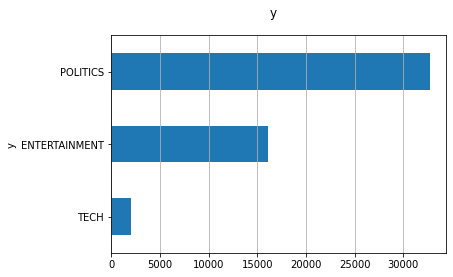

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [11]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [12]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords[::10]

['i',
 "you've",
 'himself',
 'they',
 'that',
 'been',
 'a',
 'while',
 'through',
 'in',
 'here',
 'few',
 'own',
 'just',
 're',
 'doesn',
 'ma',
 "shouldn't"]

In [13]:
dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


In [14]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

# Bag of Words

In [ ]:
## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [ ]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
corpus

87040     taylor swift emma watson together magical hogw...
38152        courier thrilled donald trump prefers computer
40220     pretty little liar star troian bellisario wed ...
10683     minister roy moore event history covering accu...
65629     lindsey graham back work hill he still going d...
                                ...                        
172850                        watch 60 second social medium
69735             state union reimagined wes anderson movie
36608            president trump told cia u stolen iraq oil
146444    lady gaga miley cyrus vma reaction people need...
25541     report trump set war room repel russia probe a...
Name: text_clean, Length: 35615, dtype: object

In [ ]:
X_train

<35615x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 282766 stored elements in Compressed Sparse Row format>

In [ ]:
dic_vocabulary

{'taylor': 8674,
 'swift': 8579,
 'emma': 2897,
 'watson': 9665,
 'together': 8861,
 'magical': 5342,
 'taylor swift': 8675,
 'emma watson': 2899,
 'thrilled': 8807,
 'donald': 2636,
 'trump': 9026,
 'computer': 1850,
 'donald trump': 2637,
 'pretty': 6802,
 'little': 5202,
 'liar': 5148,
 'star': 8306,
 'wed': 9685,
 'suit': 8494,
 'patrick': 6435,
 'adam': 240,
 'ceremony': 1499,
 'pretty little': 6803,
 'little liar': 5204,
 'liar star': 5149,
 'minister': 5690,
 'roy': 7516,
 'moore': 5775,
 'event': 3023,
 'history': 4103,
 'covering': 2076,
 'accused': 210,
 'roy moore': 7517,
 'lindsey': 5184,
 'graham': 3781,
 'back': 737,
 'work': 9861,
 'hill': 4088,
 'he': 3991,
 'still': 8375,
 'going': 3694,
 'lindsey graham': 5185,
 'back work': 745,
 'play': 6619,
 'emotional': 2905,
 'tribute': 9000,
 'rachel': 6996,
 'lindsay': 5182,
 'chooses': 1609,
 'winner': 9797,
 'bachelorette': 734,
 'finale': 3291,
 'chris': 1613,
 'christie': 1630,
 'argument': 587,
 'planned': 6613,
 'parenth

Text(0.5, 1.0, 'Sparse Matrix Sample')

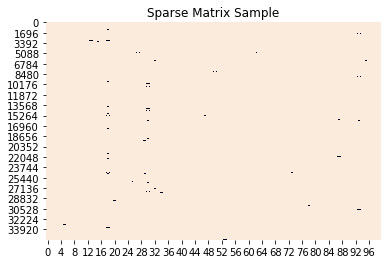

In [ ]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, 
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
dic_vocabulary["new york"]

6024

In [ ]:
from sklearn import feature_selection

In [ ]:
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [ ]:
X_names[0:10]

['actor',
 'album',
 'award',
 'box',
 'box office',
 'celebrity',
 'clinton',
 'dead',
 'democrat',
 'donald']

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# ENTERTAINMENT:
  . selected features: 3071
  . top features: actor,album,award,box,box office,celebrity,clinton,dead,democrat,donald
 
# POLITICS:
  . selected features: 3016
  . top features: album,apple,box,box office,clinton,democrat,donald,donald trump,fan,film
 
# TECH:
  . selected features: 452
  . top features: amazon,android,app,apple,apple rumor,apps,att,bug,car,content
 


In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, \
  classification_report, confusion_matrix, roc_curve, auc, \
  precision_recall_curve

In [ ]:
## classifier
classifier = MultinomialNB()

## pipeline
model = Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [ ]:
y_test[0:9]

array(['ENTERTAINMENT', 'POLITICS', 'ENTERTAINMENT', 'POLITICS',
       'POLITICS', 'ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS',
       'POLITICS'], dtype=object)

In [ ]:
predicted[0:9]

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS',
       'POLITICS', 'POLITICS', 'ENTERTAINMENT', 'POLITICS', 'POLITICS'],
      dtype='<U13')

In [ ]:
# del auc

PERFORMANCE EVALUATION

Accuracy: 0.91
Auc: 0.97
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.88      0.90      4818
     POLITICS       0.91      0.97      0.94      9843
         TECH       0.93      0.33      0.48       603

     accuracy                           0.91     15264
    macro avg       0.92      0.72      0.77     15264
 weighted avg       0.91      0.91      0.91     15264



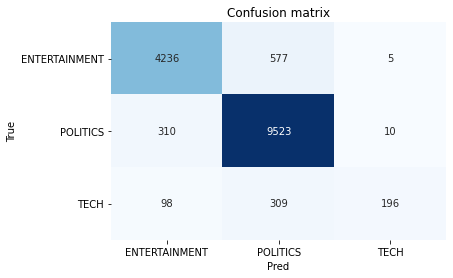

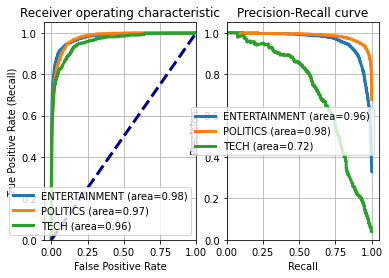

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = accuracy_score(y_test, predicted)
auc_score = roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc_score,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

EXPLANATION

In [ ]:
import random

## select observation
# i = 0
i = random.randint(0, len(dtf_test['text']))
txt_instance = dtf_test["text"].iloc[i]
print(txt_instance)
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

No Animals Were Harmed On Set Of 'A Dog's Purpose,' According To Investigation
True: ENTERTAINMENT --> Pred: ENTERTAINMENT | Prob: 0.5


# Word Embedding

In [ ]:
nlp = gensim_api.load("word2vec-google-news-300")

In [ ]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
word = "data"
# print(nlp.wv[word])
nlp.wv[word].shape

(300,)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


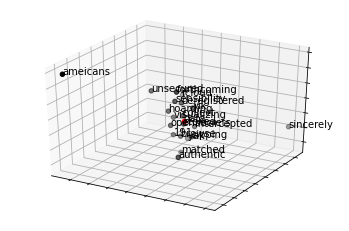

In [ ]:
word = "data"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

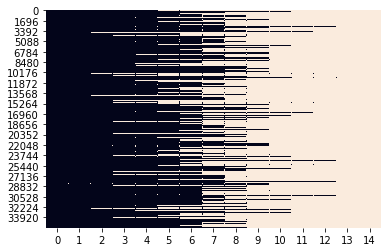

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  taylor swift emma watson together magical hogwarts | len: 7
to:  [ 151  165 1061 3005  624 2612 6570    0    0    0    0    0    0    0
    0] | len: 15
check:  taylor  -- idx in vocabulary --> 151
vocabulary:  {'NaN': 1, 'trump': 2, 'donald': 3, 'new': 4, 'say': 5} ... (padding element, 0)


FEATURE ENGINEERING ON TEST SET

In [ ]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

dic[word]: 554 |idx
embeddings[idx]: (300,) |vector


# Build the Deep Learning Model

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      6742800     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
______________________________________________________________________________________________

Model Training and Performance Check

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

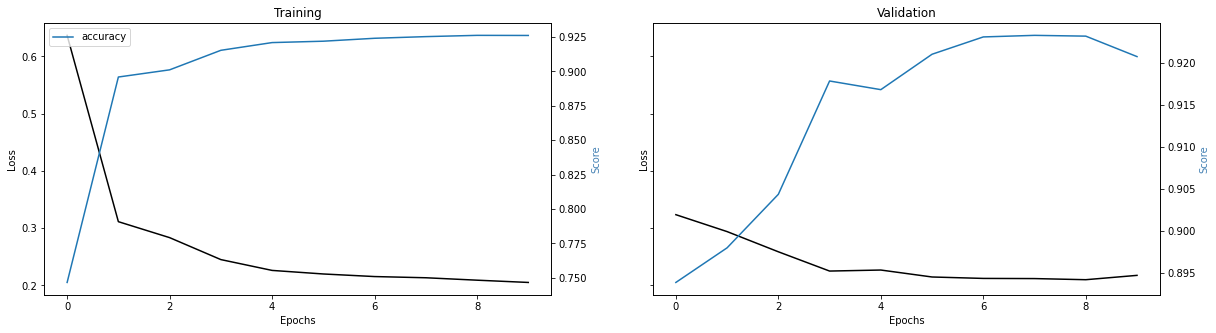

In [ ]:
## plot loss and accuracy
metrics_record = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics_record:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics_record:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
metrics_record

['accuracy']

In [ ]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Accuracy: 0.86
Auc: 0.94
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.68      0.78      4818
     POLITICS       0.85      0.96      0.90      9843
         TECH       0.65      0.52      0.58       603

     accuracy                           0.86     15264
    macro avg       0.80      0.72      0.75     15264
 weighted avg       0.86      0.86      0.85     15264



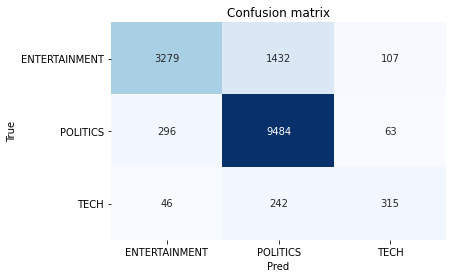

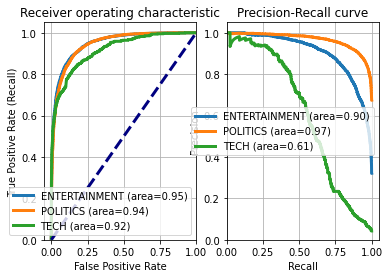

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy2 = accuracy_score(y_test, predicted)
auc_score2 = roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy2,2))
print("Auc:", round(auc_score2,2))
print("Detail:")
print(classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

True: ENTERTAINMENT --> Pred: POLITICS | Prob: 0.78


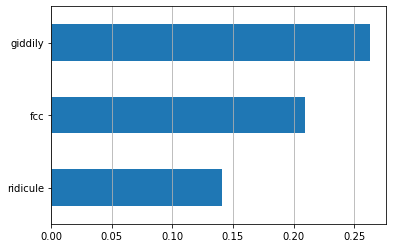

Text with highlighted words


In [ ]:
## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(corpus), maxlen=15, 
              padding="post", truncating="post")
### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in 
         layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()
### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx 
           != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(lst_corpus[0]) if word in 
                   tokenizer.word_index.keys()}
### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', 
                                columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)
### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

# Language Modelling with BERT

A. Data Frame

In [112]:
dtf_train.head()

,y,text,text_clean
111311,POLITICS,GOP Challenger Slams Jerry Brown As The ‘Coddl...,gop challenger slam jerry brown coddled prince...
80315,ENTERTAINMENT,Kylie Jenner And Tyga Bring Their Romance To N...,kylie jenner tyga bring romance new york fashi...
44505,POLITICS,Arizona Residents Call Trump's Wall A 'Waste O...,arizona resident call trump wall waste money
9083,POLITICS,Wednesday's Morning Email: Republicans On Cusp...,wednesday morning email republican cusp passin...
107875,POLITICS,Will Working Moms Show Up on Election Day?,working mom show election day


In [113]:
dtf_test.head()

,y,text,text_clean
60930,POLITICS,"After Big New York Wins, Trump And Clinton Cas...",big new york win trump clinton cast inevitable
135169,ENTERTAINMENT,'Kung Fury' Is The Over-The-Top 80s Renegade C...,kung fury overthetop 80 renegade cop movie wev...
14445,ENTERTAINMENT,Cory Booker Tells Seth Meyers That U.S. Must U...,cory booker tell seth meyers u must unite gun ...
139116,ENTERTAINMENT,Academy Of Motion Picture Arts And Sciences Ho...,academy motion picture art science honor angel...
93392,ENTERTAINMENT,Bill Paxton Learns of His Revolutionary Past O...,bill paxton learns revolutionary past think


In [114]:
train_set = dtf_train.reset_index()
train_set.drop(columns='index', inplace=True)
train_set.head()

,y,text,text_clean
0,POLITICS,GOP Challenger Slams Jerry Brown As The ‘Coddl...,gop challenger slam jerry brown coddled prince...
1,ENTERTAINMENT,Kylie Jenner And Tyga Bring Their Romance To N...,kylie jenner tyga bring romance new york fashi...
2,POLITICS,Arizona Residents Call Trump's Wall A 'Waste O...,arizona resident call trump wall waste money
3,POLITICS,Wednesday's Morning Email: Republicans On Cusp...,wednesday morning email republican cusp passin...
4,POLITICS,Will Working Moms Show Up on Election Day?,working mom show election day


In [115]:
test_set = dtf_test.reset_index()
test_set.drop(columns='index', inplace=True)
test_set.head()

,y,text,text_clean
0,POLITICS,"After Big New York Wins, Trump And Clinton Cas...",big new york win trump clinton cast inevitable
1,ENTERTAINMENT,'Kung Fury' Is The Over-The-Top 80s Renegade C...,kung fury overthetop 80 renegade cop movie wev...
2,ENTERTAINMENT,Cory Booker Tells Seth Meyers That U.S. Must U...,cory booker tell seth meyers u must unite gun ...
3,ENTERTAINMENT,Academy Of Motion Picture Arts And Sciences Ho...,academy motion picture art science honor angel...
4,ENTERTAINMENT,Bill Paxton Learns of His Revolutionary Past O...,bill paxton learns revolutionary past think


In [116]:
print(len(train_set))
print(len(test_set))

35615
15264


In [117]:
print(dtf_train.y.unique())
print(dtf_test.y.unique())

['POLITICS' 'ENTERTAINMENT' 'TECH']
['POLITICS' 'ENTERTAINMENT' 'TECH']


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', 
                                                       do_lower_case=True)

nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

lst_vocabulary = list(tokenizer.vocab.keys())

In [18]:
# txt = "bank river"
# ## return hidden layer with embeddings
# input_ids = np.array(tokenizer.encode(txt))[None,:]  
# embedding = nlp(input_ids)
# embedding[0][0]

In [19]:
# corpus = dtf_train["text"]
# maxlen = 50

# ## add special tokens
# maxqnans = np.int((maxlen-20)/2)
# corpus_tokenized = ["[CLS] "+
#              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
#              str(txt).lower().strip()))[:maxqnans])+
#              " [SEP] " for txt in corpus]

# ## generate masks
# masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
#            txt.split(" "))) for txt in corpus_tokenized]
    
# ## padding
# txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

# ## generate idx
# idx = [tokenizer.encode(seq) for seq in txt2seq]

# ## generate segments
# segments = [] 
# for seq in txt2seq:
#     temp, i = [], 0
#     for token in seq.split(" "):
#         temp.append(i)
#         if token == "[SEP]":
#              i += 1
#     segments.append(temp)
# ## feature matrix
# X_train = [np.asarray(idx, dtype='int32'), 
#            np.asarray(masks, dtype='int32'), 
#            np.asarray(segments, dtype='int32')]

In [20]:
# text1 = train_set['text_clean'][0]

In [21]:
# # example of tokenizing with tokenize function
# tkzd1 = tokenizer.tokenize(text1)

# print(tkzd1)

['go', '##p', 'challenger', 'slam', 'jerry', 'brown', 'cod', '##dled', 'prince', 'sacramento']


In [22]:
# # encoding text with encode function 
# # by adding special tokens [CLS]=101 and [SEP]=102 
# idx1 = tokenizer.encode(text1, add_special_tokens=True, 
#                         max_length=50, truncation=True,)
# print(idx1)

[101, 2175, 2361, 12932, 9555, 6128, 2829, 19429, 20043, 3159, 11932, 102]


In [23]:
# # convert encoded text (ids) into tokens
# tkzd2 = tokenizer.convert_ids_to_tokens(idx1)
# tkzd2

['[CLS]',
 'go',
 '##p',
 'challenger',
 'slam',
 'jerry',
 'brown',
 'cod',
 '##dled',
 'prince',
 'sacramento',
 '[SEP]']

In [24]:
# # encodes list of tokens with encode_plus function.
# # returns input_ids, attention_mask, special_tokens_mask
# encoded1 = tokenizer.encode_plus(text1, 
#                              add_special_tokens=True,
#                              padding=True,
#                              truncation=True, 
#                              max_length=50,
#                              return_attention_mask=True,
#                              return_special_tokens_mask=True)

# for key, value in encoded1.items():
#   print(f"{key}: {value}")

input_ids: [101, 2175, 2361, 12932, 9555, 6128, 2829, 19429, 20043, 3159, 11932, 102]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
special_tokens_mask: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [150]:
def data_tokenizer_encoder(dataframe, column):
  data = dataframe[column].values.tolist()
  
  tokenized = tokenizer(text=data, add_special_tokens=True,
                        padding='max_length', truncation=True, 
                        max_length=50, return_token_type_ids=True,
                        return_attention_mask=True, return_tensors='np')
  return tokenized


In [151]:
X_train = data_tokenizer_encoder(dtf_train, 'text_clean')
X_test = data_tokenizer_encoder(dtf_test, 'text_clean')

In [121]:
# train_sentences = train_set['text_clean'].values.tolist()
# train_labels = train_set['y'].values.tolist()

# print(len(train_sentences), len(train_labels))

# test_sentences = test_set['text_clean'].values.tolist()
# test_labels = test_set['y'].values.tolist()

# print(len(test_sentences), len(test_labels))

35615 35615
15264 15264


In [77]:
# X_train = tokenizer(text=train_sentences, add_special_tokens=True,
#                     padding='max_length', truncation=True, max_length=50,
#                     return_token_type_ids=True,
#                     return_attention_mask=True,
#                     return_tensors='np')

# X_test = tokenizer(text=test_sentences, add_special_tokens=True,
#                     padding='max_length', truncation=True, max_length=50,
#                     return_token_type_ids=True,
#                     return_attention_mask=True,
#                     return_tensors='np')

In [180]:
y_train = tokenizer.encode(text=train_labels, add_special_tokens=False,
                           return_token_type_ids=False,
                            return_attention_mask=False,
                           return_tensors='np', is_split_into_words=True)
y_test = tokenizer.encode(text=test_labels, add_special_tokens=True, 
                          return_token_type_ids=False,
                          return_attention_mask=False,
                           return_tensors='np', is_split_into_words=True)

In [153]:
y_train.shape

(1, 35615)

In [83]:
print(X_train['input_ids'][0])
print(X_train['token_type_ids'][0])
print(X_train['attention_mask'][0])

[  101  2175  2361 12932  9555  6128  2829 19429 20043  3159 11932   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [128]:
print(X_train)

{'input_ids': <tf.Tensor: shape=(35615, 50), dtype=int32, numpy=
array([[  101,  2175,  2361, ...,     0,     0,     0],
       [  101,  9008, 15419, ...,     0,     0,     0],
       [  101,  5334,  6319, ...,     0,     0,     0],
       ...,
       [  101, 21301, 19894, ...,     0,     0,     0],
       [  101,  9733,  4518, ...,     0,     0,     0],
       [  101, 15941,  5472, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(35615, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(35615, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [145]:
train = np.array([
                  X_train['input_ids'],
                  X_train['token_type_ids'],
                  X_train['attention_mask'],
                  y_train
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [156]:
test = np.array([
                 X_test['input_ids'],
                 X_test['token_type_ids'],
                 X_test['attention_mask'],
                 y_test
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [142]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [155]:
y_train.reshape(1, 35615).reshape((35615, 1)); 
print(y_train.shape)
print(type(y_train))
# y_test.reshape(1, 15264).reshape((15264, 1));

(1, 35615)
<class 'numpy.ndarray'>


In [159]:
type(X_train.input_ids)

numpy.ndarray

In [136]:
X_train['input_ids'][]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([  101,  9008, 15419,  3678,  5939,  3654,  3288,  7472,  2047,
        2259,  4827,  2733,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)>

In [32]:
## input layers
idx_layer = layers.Input((50), dtype="int32", name='input_idx')
masks_layer = layers.Input((50), dtype="int32", name='input_masks')

## configuration for DistilledBERT 
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', 
                                                     config=config)

bert_out = nlp(idx_layer, attention_mask=masks_layer)[0]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [33]:
## fine tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

In [34]:
## compile the model
model = models.Model([idx_layer, masks_layer], y_out)
for layer in model.layers[:3]:
  layer.trainable=False

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model_1[0][0] 

In [164]:
type(train)
# train = np.asarray(train).astype(np.float32)

numpy.ndarray

In [196]:
history = model.fit(x=np.array(
                              [[X_train['input_ids'], 
                               X_train['attention_mask']]]), 
                    y=np.array([y]),
                    epochs=10, batch_size=10)#, 
                    #validation_data=(test_data, y_test))

Epoch 1/10


ValueError: ignored